<a href="https://colab.research.google.com/github/Shivagharehzad95/Autoregression.ipynb/blob/main/Autoregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [ ]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Standardize.
    for path in paths_all:
        content = open(path).read()
        content = content.lower()
        for punctuation in ".,:;?!":
            content = content.replace(punctuation, " " + punctuation)
        open(path, "w").write(content)

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

Cloning into 'lovecraftcorpus'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 74 (delta 0), reused 3 (delta 0), pack-reused 70 (from 1)
Receiving objects: 100% (74/74), 1.12 MiB | 2.57 MiB/s, done.
['lovecraftcorpus/alchemist.txt', 'lovecraftcorpus/arthur_jermyn.txt', 'lovecraftcorpus/azathoth.txt', 'lovecraftcorpus/beast.txt', 'lovecraftcorpus/beyond_wall_of_sleep.txt', 'lovecraftcorpus/book.txt', 'lovecraftcorpus/celephais.txt', 'lovecraftcorpus/charles_dexter_ward.txt', 'lovecraftcorpus/clergyman.txt', 'lovecraftcorpus/colour_out_of_space.txt', 'lovecraftcorpus/cool_air.txt', 'lovecraftcorpus/crawling_chaos.txt', 'lovecraftcorpus/cthulhu.txt', 'lovecraftcorpus/dagon.txt', 'lovecraftcorpus/descendent.txt', 'lovecraftcorpus/doorstep.txt', 'lovecraftcorpus/dreams_in_the_witch.txt', 'lovecraftcorpus/dunwich.txt', 'lovecraftcorpus/erich_zann.txt', 'lovecraftcorpus/ex_oblivione.txt', 'lovec

In [ ]:
batch_size = 32 # !!! Not for training!
seed = 42 # Seed for the random number generator.

def create_dataset(dataset_path):
    dataset = preprocessing.text_dataset_from_directory(
        dataset_path,
        labels=None,
        batch_size=batch_size,
        seed=seed
    )
    return dataset

dataset_original_all   = create_dataset(dataset_path_all)
dataset_original_train = create_dataset(dataset_path_train)
dataset_original_valid = create_dataset(dataset_path_valid)

Found 20 files.
Found 16 files.
Found 4 files.


In [ ]:
for short_story_list in dataset_original_all:
    for short_story in short_story_list:
        print(short_story)

tf.Tensor(b'ex oblivione\n\nwhen the last days were upon me , and the ugly trifles of existence began to drive me to madness like the small drops of water that torturers let fall ceaselessly upon one spot of their victims body , i loved the irradiate refuge of sleep . in my dreams i found a little of the beauty i had vainly sought in life , and wandered through old gardens and enchanted woods .\n\nonce when the wind was soft and scented i heard the south calling , and sailed endlessly and languorously under strange stars .\n\nonce when the gentle rain fell i glided in a barge down a sunless stream under the earth till i reached another world of purple twilight , iridescent arbours , and undying roses .\n\nand once i walked through a golden valley that led to shadowy groves and ruins , and ended in a mighty wall green with antique vines , and pierced by a little gate of bronze .\n\nmany times i walked through that valley , and longer and longer would i pause in the spectral half-light w

# Sliding window - Dataset for Autoregression

In [ ]:
vocabulary_size = 10_000

encoder = layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None, # Already done!
    split="whitespace",
    output_mode="int" # Word indices. As usual. SOTA!
)
encoder.adapt(dataset_original_all)

vocabulary = encoder.get_vocabulary()
vocabulary[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_(','),
 np.str_('and'),
 np.str_('of'),
 np.str_('.'),
 np.str_('to'),
 np.str_('a'),
 np.str_('in')]

In [ ]:
sequence_length = 32
padding_token_id = 0

def create_dataset_for_autoregression(dataset, hop_length=1):
    x_inputs = []
    y_outputs = []

    for books in dataset:
        books = encoder(books).numpy()

        for book in tqdm(books):

            # Remove the padding token.
            book = [int(index) for index in list(book) if index != padding_token_id]

            for start_index in range(0, len(book) - sequence_length, hop_length):
                x = book[start_index:start_index + sequence_length]
                assert len(x) == sequence_length
                y = book[start_index + 1:start_index + sequence_length + 1] # Plot twist!
                assert len(y) == sequence_length
                x_inputs.append(x)
                y_outputs.append(y)

    return tf.data.Dataset.from_tensor_slices((x_inputs, y_outputs))

dataset_train = create_dataset_for_autoregression(dataset_original_train)
dataset_valid = create_dataset_for_autoregression(dataset_original_valid)

100%|██████████| 4/4 [00:00<00:00, 276.35it/s]


In [ ]:
def decode(indices):
    return " ".join([str(vocabulary[index]) for index in indices])


for x, y in dataset_train.shuffle(100):
    print(decode(x))
    print(decode(y))
    break # TODO: Remove later.

experiences possess any esthetic significance , and that it is the province of the artist not so much to rouse strong emotion by action , ecstasy , and astonishment , as to
possess any esthetic significance , and that it is the province of the artist not so much to rouse strong emotion by action , ecstasy , and astonishment , as to [UNK]


In [ ]:
import matplotlib.pyplot as plt

def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

# Train a model.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 32, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32, 10000)      │     1,290,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,701,584 (10.31 MB)

 Trainable params: 2,701,584 (10.31 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 58s 297ms/step - accuracy: 0.0573 - loss: 7.3622 - val_accuracy: 0.0609 - val_loss: 6.5992
Epoch 2/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 80s 296ms/step - accuracy: 0.0608 - loss: 6.4699 - val_accuracy: 0.0886 - val_loss: 6.5292
Epoch 3/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 57s 307ms/step - accuracy: 0.0907 - loss: 6.3200 - val_accuracy: 0.1077 - val_loss: 6.2496
Epoch 4/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 58s 312ms/step - accuracy: 0.1058 - loss: 6.0493 - val_accuracy: 0.1211 - val_loss: 6.1151
Epoch 5/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 58s 314ms/step - accuracy: 0.1211 - loss: 5.8755 - val_accuracy: 0.1401 - val_loss: 6.0056
Epoch 6/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 58s 314ms/step - accuracy: 0.1460 - loss: 5.7113 - val_accuracy: 0.1460 - val_loss: 5.9251
Epoch 7/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 59s 319ms/step - accuracy: 0.1602 - loss: 5.5740 - val_accuracy: 0.1486 - val_loss: 5.8922
Epoch 8/10
185/185 ━━━━━━━━━━━━━━━━━━━━ 83s 323ms/step - accuracy: 0.1698 - loss: 5

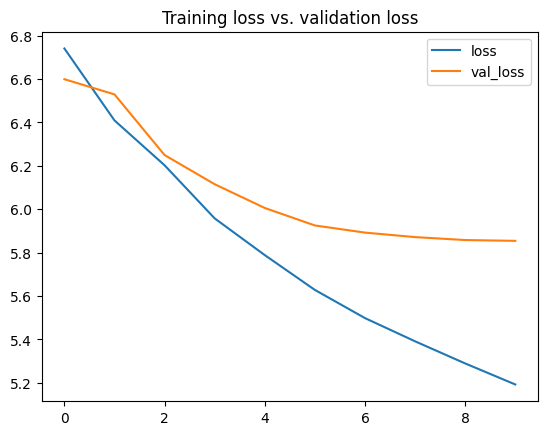

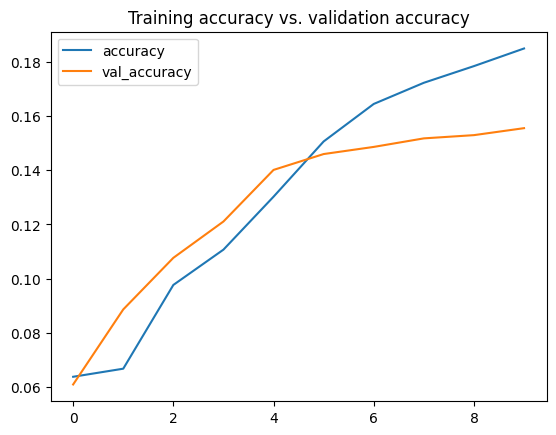

In [ ]:
embedding_size = 128

model = models.Sequential()
model.add(layers.Embedding(vocabulary_size, embedding_size, input_length=sequence_length))
model.add(layers.LSTM(embedding_size, return_sequences=True))
model.add(layers.Dense(vocabulary_size, activation="softmax"))
model.build(input_shape=(None, sequence_length)) # ?
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train.cache().shuffle(20_000).batch(1024),
    epochs=10,
    validation_data=dataset_valid.cache().batch(1024)
)

render_history(history)

In [ ]:
100 / 10_000

0.01

In [ ]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    seed_text = seed_text.lower()
    for punctuation in ".,:;?!":
        seed_text = seed_text.replace(punctuation, " " + punctuation)

    input_sequence = encoder(seed_text).numpy().tolist()

    # Generate the sequence by repeatedly predicting.
    while len(input_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=False)
        predicted_index = get_index_from_prediction(prediction[0][-1], temperature)
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(input_sequence)
    for punctuation in ".,:;?!":
        text = text.replace(" " + punctuation, punctuation)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')
        prediction = np.log(prediction) / temperature
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction)
        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, "we are all doomed", 100, temperature=1.0)

we are all doomed, [UNK] and [UNK], and done it is without the sea-green [UNK] and a old source calling built my his avalanche experimental coil and illimitable shaky trumpets and hoary. sand again rate of whole blood-trail than an changes for no [UNK] chuckled traveling to help the [UNK] and we darted a hippopotamus in a idle scene when they had [UNK]. whether for the landing poised with mnar and all me barry became pains to spice and having; but having [UNK] enough. repeated corey. must have see egypt among our [UNK]

